#  Forecasting taxi orders

The company "Chetenkoe Taxi" has collected historical data on taxi orders at airports. In order to attract more drivers during peak load, we need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the RMSE metric in the test sample should be no more than 48.

We need to:

* Download the data and resample it one hour at a time.
* Analyze the data.
* Train different models with different hyperparameters. Make a test sample of 10% of the original data.
* Check the data on the test sample and draw conclusions.

The data is in the `taxi.csv` file. The number of orders is in the num_orders column.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

## Preparation

In [2]:
df = pd.read_csv('datasets/taxi.csv', parse_dates = [0], index_col = [0])
df.sort_index(inplace=True)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
# resampling by 1 hour
df = df.resample('1H').sum()

In [4]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [6]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


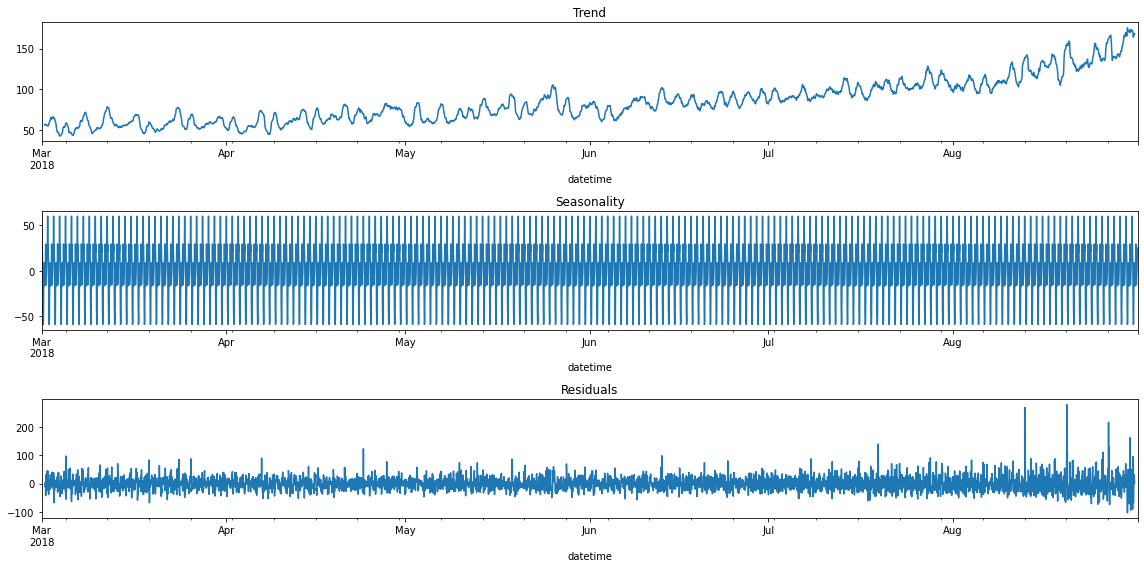

In [7]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(16, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

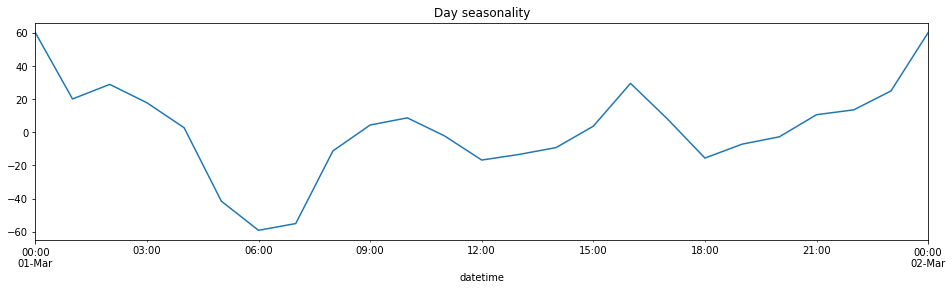

In [8]:
plt.figure(figsize=(16, 4))
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 00:00:00'].plot()
plt.title('Day seasonality');

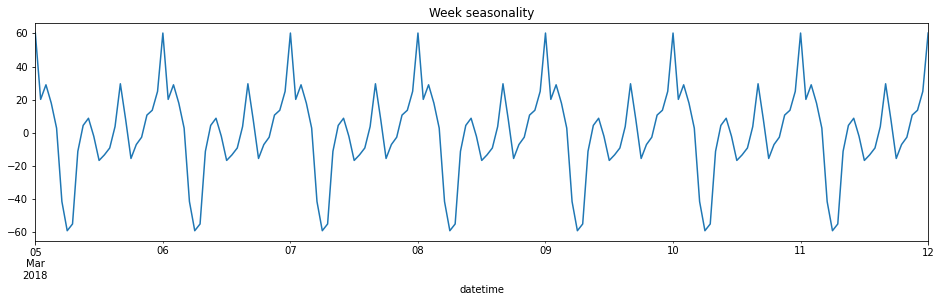

In [9]:
plt.figure(figsize=(16, 4))
decomposed.seasonal['2018-03-05 00:00:00':'2018-03-12 00:00:00'].plot()
plt.title('Week seasonality');

### Conclusion

The data consists of 4416 rows

Resampling was carried out for 1 hour (summation)

An uptrend has been identified, no distinct seasonality is detected on these resampled data, a larger spread is visible by the end of the year according to the balance chart

If we build, for example, a seasonality schedule for 1 day from March 1, 2018 to March 2, 2018, then we will see that demand is lowest at 6 am, and highest at 00:00

## Training

### Creating features and dividing data into training and test samples

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
make_features(df, 20, 20)

In [12]:
df

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,169.35
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,163.85
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,157.75


In [13]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
print(train.shape)
print(test.shape)
train = train.dropna()
test = test.dropna()

features_train = train.drop(columns='num_orders')
target_train = train['num_orders']

features_test = test.drop(columns='num_orders')
target_test = test['num_orders']

(3974, 26)
(442, 26)


### Learning linear regression

In [14]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

predictions_train = model_lr.predict(features_train)

print("RMSE training sample:", round(mean_squared_error(target_train,predictions_train)**0.5,3))

RMSE training sample: 29.249
Wall time: 22.9 ms


### Random Forest Regressor

In [15]:
%%time
rfr = RandomForestRegressor(random_state = 12345,criterion = "mse")
params_rfr = {'max_depth':range(3,8), 'n_estimators':range(10, 31, 10)}

# When working with time series, standard cross-validation cannot be used, since at a certain point the training sample 
# will be later than the validation one. To solve this problem, it is worth using Time Series Split

tscv = TimeSeriesSplit(n_splits=2)
rfr_grid = GridSearchCV(estimator=rfr, param_grid=params_rfr, cv=tscv)
rfr_grid.fit(features_train, target_train)
rfr_grid.best_params_

Wall time: 8.48 s


{'max_depth': 7, 'n_estimators': 30}

In [16]:
%%time
rfr = RandomForestRegressor(max_depth = rfr_grid.best_params_['max_depth'], 
                            n_estimators = rfr_grid.best_params_['n_estimators'],random_state = 12345,criterion = "mse")

rfr.fit(features_train, target_train)
predictions_train = rfr.predict(features_train)
print("RMSE training sample:", round(mean_squared_error(target_train,predictions_train)**0.5,3))

RMSE training sample: 22.21
Wall time: 997 ms


### Cat Boost

In [17]:
%%time
catboost = CatBoostRegressor(loss_function='RMSE')
params_cat = {'depth':range(3,8), 'learning_rate':np.arange(0.1,1,0.3)}

catboost_grid = GridSearchCV(catboost, params_cat, cv=tscv)
catboost_grid.fit(features_train, target_train,verbose=100)
catboost_grid.best_params_

0:	learn: 29.5217090	total: 138ms	remaining: 2m 17s
100:	learn: 18.8669659	total: 296ms	remaining: 2.63s
200:	learn: 15.9082065	total: 444ms	remaining: 1.77s
300:	learn: 13.8379932	total: 591ms	remaining: 1.37s
400:	learn: 12.6199261	total: 739ms	remaining: 1.1s
500:	learn: 11.4960727	total: 883ms	remaining: 880ms
600:	learn: 10.5726819	total: 1.03s	remaining: 683ms
700:	learn: 9.7364936	total: 1.18s	remaining: 505ms
800:	learn: 9.0662956	total: 1.34s	remaining: 334ms
900:	learn: 8.4689474	total: 1.5s	remaining: 165ms
999:	learn: 7.9090915	total: 1.65s	remaining: 0us
0:	learn: 32.5380775	total: 2.29ms	remaining: 2.29s
100:	learn: 21.7583777	total: 205ms	remaining: 1.83s
200:	learn: 19.3641473	total: 400ms	remaining: 1.59s
300:	learn: 17.8072615	total: 599ms	remaining: 1.39s
400:	learn: 16.6082275	total: 790ms	remaining: 1.18s
500:	learn: 15.6522301	total: 986ms	remaining: 982ms
600:	learn: 14.8044470	total: 1.17s	remaining: 777ms
700:	learn: 14.1010215	total: 1.36s	remaining: 581ms
800

{'depth': 4, 'learning_rate': 0.1}

In [18]:
%%time
catboost = CatBoostRegressor(depth = catboost_grid.best_params_['depth'], learning_rate = catboost_grid.best_params_['learning_rate'], loss_function='RMSE')
catboost.fit(features_train, target_train,verbose=100)
predictions_train = catboost.predict(features_train)
print("RMSE training sample:", round(mean_squared_error(target_train,predictions_train)**0.5,3))

0:	learn: 37.6154128	total: 3.67ms	remaining: 3.67s
100:	learn: 24.1251918	total: 336ms	remaining: 2.99s
200:	learn: 21.0767433	total: 674ms	remaining: 2.68s
300:	learn: 19.1976069	total: 993ms	remaining: 2.31s
400:	learn: 17.8580289	total: 1.33s	remaining: 1.99s
500:	learn: 16.7350834	total: 1.67s	remaining: 1.66s
600:	learn: 15.7770145	total: 1.97s	remaining: 1.31s
700:	learn: 14.9083992	total: 2.28s	remaining: 973ms
800:	learn: 14.1653524	total: 2.6s	remaining: 645ms
900:	learn: 13.4261920	total: 2.91s	remaining: 320ms
999:	learn: 12.8033089	total: 3.23s	remaining: 0us
RMSE training sample: 12.803
Wall time: 3.43 s


## Testing

### Linear Regression

In [19]:
predictions_test = model_lr.predict(features_test)
print("RMSE testing sample: ", round(mean_squared_error(target_test,predictions_test)**0.5,3))

RMSE testing sample:  55.24


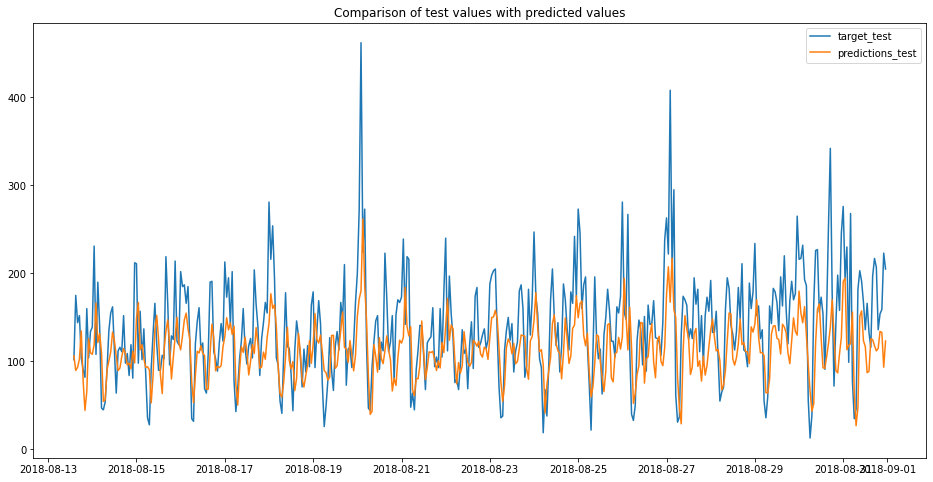

In [20]:
plt.figure(figsize=(16, 8))

plt.plot(target_test, label='target_test')
plt.plot(target_test.index, predictions_test, label='predictions_test')

plt.title('Comparison of test values with predicted values')
plt.legend()
plt.show()

### Random Forest Regressor

In [21]:
predictions_test = rfr.predict(features_test)
print("RMSE testing sample: ", round(mean_squared_error(target_test,predictions_test)**0.5,3))

RMSE testing sample:  56.585


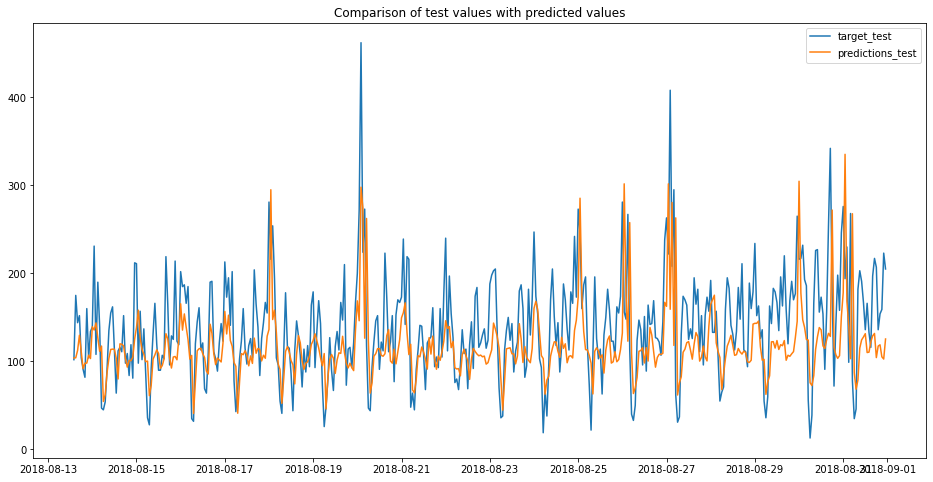

In [22]:
plt.figure(figsize=(16, 8))

plt.plot(target_test, label='target_test')
plt.plot(target_test.index, predictions_test, label='predictions_test')

plt.title('Comparison of test values with predicted values')
plt.legend()
plt.show()

### CatBoost

In [23]:
predictions_test = catboost.predict(features_test)
print("RMSE testing sample: ", round(mean_squared_error(target_test,predictions_test)**0.5,3))

RMSE testing sample:  47.699


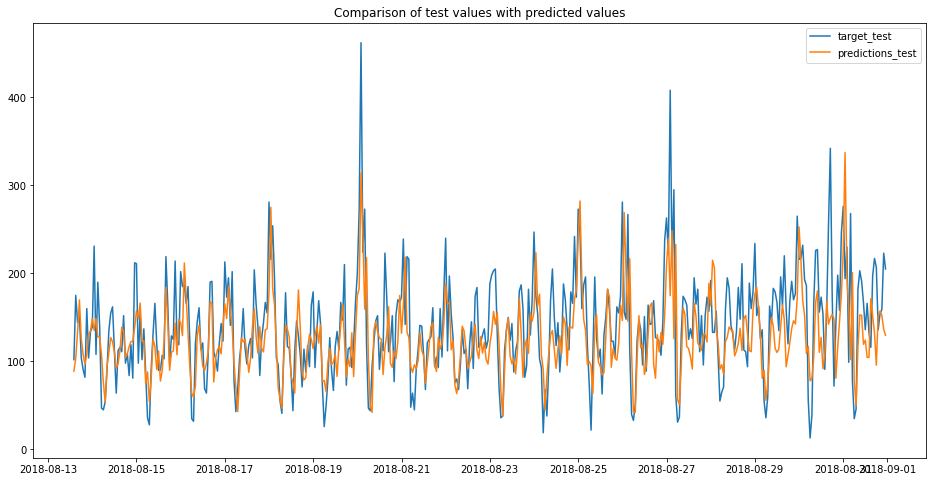

In [24]:
plt.figure(figsize=(16, 8))

plt.plot(target_test, label='target_test')
plt.plot(target_test.index, predictions_test, label='predictions_test')

plt.title('Comparison of test values with predicted values')
plt.legend()
plt.show()

## Conclusion

- The best RMS indicator on the training and test samples was obtained using the Cat Boost model